# Plant image classification
This is a part of semestral project for PV056 Machine Learning and Data Mining class at FI MUNI.

Authors:
* Martin Hlinský
* Šárka Blaško

Our goal was to **train a model to discriminate plant diseases** given their images. This notebook implements the Tensorflow and EfficientNetB0 to classify them.

This is one of the models we tried, for further information, see the report at https://www.overleaf.com/project/67b5c71a3ccb35ae294eda1d


# Dataset
We used PlantVillage Dataset (https://github.com/spMohanty/PlantVillage-Dataset/). This code downloads and unzipps the images to google colab for further processing.

In [ ]:
# delete variables - clean previous if any
import gc
gc.collect()

import os

dataset_dir = "/content/PlantVillage-Dataset-master/raw/color"

if not os.path.exists(dataset_dir):
    print("Zip not found, downloading...")
    !wget -q https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip
else:
    print("Zip already exists, skipping download.")

Zip not found, downloading...


In [ ]:
if not os.path.exists(dataset_dir):
    print("Dataset not found, unzipping...")
    !unzip -q master.zip -d .
else:
    print("Dataset already exists, skipping unzipping.")

Dataset not found, unzipping...


Now, let's take a look at the dataset. We list the classes that we have and take a look at some images.

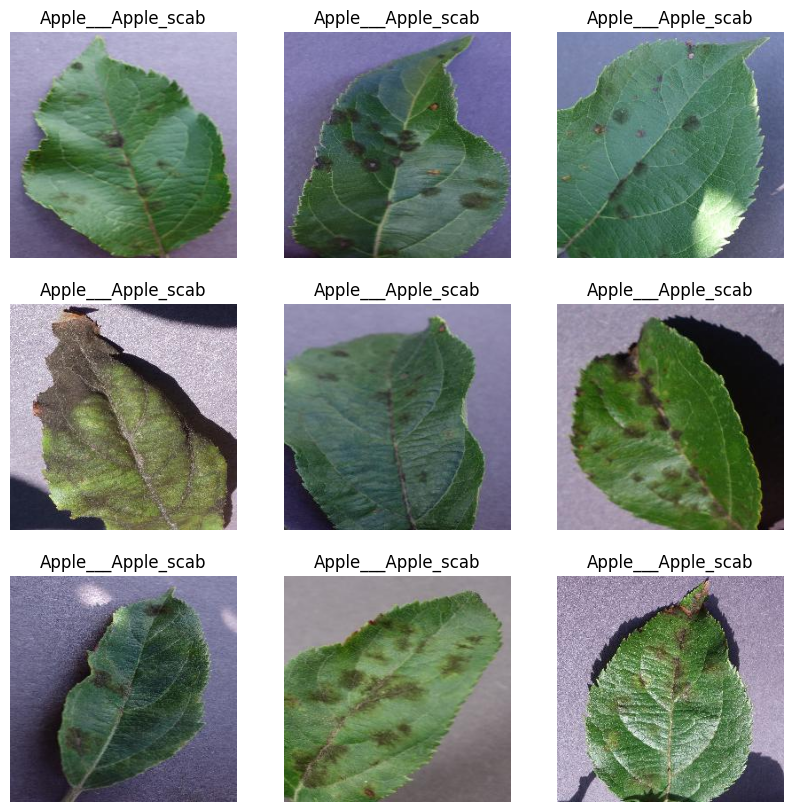

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import datetime
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Path to dataset
dataset_path = "/content/PlantVillage-Dataset-master/raw/color"

# Find first class folder
first_class = sorted(os.listdir(dataset_path))[0]
image_folder = os.path.join(dataset_path, first_class)

# Get first 9 image paths (sorted for consistency)
image_files = sorted([os.path.join(image_folder, f)
                      for f in os.listdir(image_folder)
                      if f.lower().endswith('.jpg')])[:9]

# Plot images
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_files):
    img = Image.open(image_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(first_class)
    plt.axis("off")

plt.show()


# Train a model

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [ ]:
start_time = datetime.datetime.now()

# --- Data Augmentation ---
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# --- Early stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore weights from the epoch with the best value of monitored quantity
)

# --- Dataset Path and Loading ---
dataset_path = "/content/PlantVillage-Dataset-master/raw/color"
batch_size = 32
img_height = 224
img_width = 224
seed = 123
AUTOTUNE = tf.data.AUTOTUNE

# tensorflow supports 2 way split, so if we want train, test and validation dataset, we have to do it differently:
# Step 1: Split 90% train_val, 10% test
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


# Get class names
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes: ", num_classes, "\n")

# Step 2: Manually split train_val_ds into train and val (e.g. 7:2 ratio of 90%)
train_val_batches = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_batches * 0.777)  # ~70% of original
val_size = train_val_batches - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)


# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# --- Model Definition ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

input_tensor = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(input_tensor)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Training ---
print("Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping],
)

print("\n","Training finished.")
total_time = datetime.datetime.now() - start_time
print("Total training time: ", total_time)

Found 54305 files belonging to 38 classes.
Using 48875 files for training.
Found 54305 files belonging to 38 classes.
Using 5430 files for validation.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,387,273 (16.74 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training...
Epoch 1/20
1187/1187 - 146s - 123ms/step - accuracy: 0.8303 - loss: 0.5762 - val_accuracy: 0.9305 - val_loss: 0.2176
Epoch 2/20
1187/1187 - 132s - 111ms/step - accuracy: 0.9124 - loss: 0.2736 - val_accuracy: 0.9550 - val_loss: 0.1377
Epoch 3/20
1187/1187 - 163s - 138ms/step - accuracy: 0.9210 - loss: 0.2344 - val_accuracy: 0.9501 - val_loss: 0.1417
Epoch 4/20
1187/1187 - 132s - 111ms/step - accuracy: 0.9302 - loss: 0.2076 - val_accuracy: 0.9599 - val_loss: 0.1178
Epoch 5/20
1187/1187 - 132s - 111ms/step - accuracy: 0.9324 - loss: 0.2004 - val_accuracy: 0.9560 - val_loss: 0.1263
Epoch 6/20
1187/1187 - 133s - 112ms/step - accuracy: 0.9354 - loss: 0.1894 - val_accuracy: 0.9582 - val_loss: 0.1215
Epoch 7/20
1187/1187 - 133s - 112ms/step - accuracy: 0.9398 - loss: 0.1775 - val_accuracy: 0.9641 - val_loss: 0.1083
Epoch 8/20
1187/1187 - 142s - 119ms/step - accuracy: 0.9388 - loss: 0.1782 - val_accuracy: 0.9566 - val_loss: 0.1261
Epoch 9/20
1187/1187 - 132s - 111ms/step - accuracy:

# Evaluate

In [ ]:
print("Evaluating on test dataset...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f"\nTest accuracy: {test_accuracy:.4f}")

Evaluating on test dataset...
170/170 - 12s - 68ms/step - accuracy: 0.9746 - loss: 0.0689

Test accuracy: 0.9746


#Visualize the results

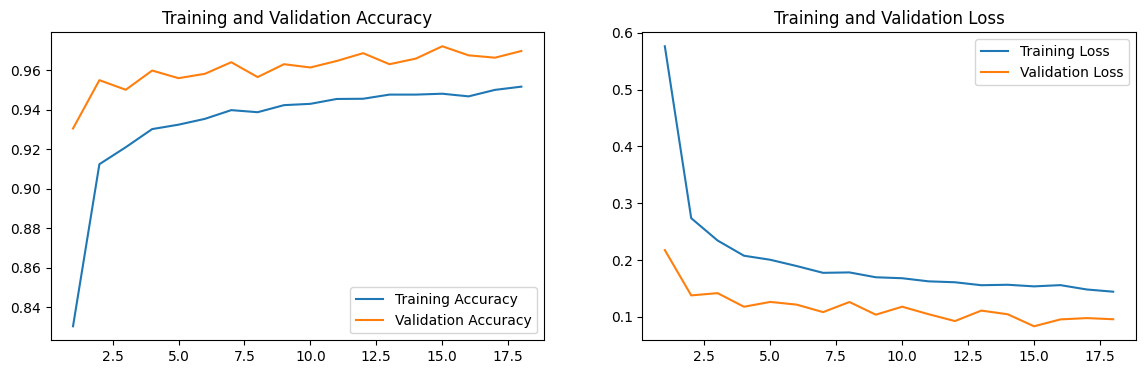

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Confusion matrix
Where did the model most mistakes?

In [ ]:
# --- Confusion Matrix ---
print("\nComputing confusion matrix...\n")
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)  # suppress individual batch logs
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

# Identify most confused classes
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            confused_pairs.append(((class_names[i], class_names[j]), cm[i][j]))

confused_pairs.sort(key=lambda x: x[1], reverse=True)
print("Top 5 most confused class pairs:")
for (actual, predicted), count in confused_pairs[:5]:
    print(f"{actual} → {predicted}: {count} times")


Computing confusion matrix...

Top 5 most confused class pairs:
Tomato___Target_Spot → Tomato___healthy: 11 times
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot → Corn_(maize)___Northern_Leaf_Blight: 8 times
Tomato___Target_Spot → Tomato___Spider_mites Two-spotted_spider_mite: 8 times
Pepper,_bell___Bacterial_spot → Pepper,_bell___healthy: 7 times
Tomato___Bacterial_spot → Tomato___Septoria_leaf_spot: 7 times


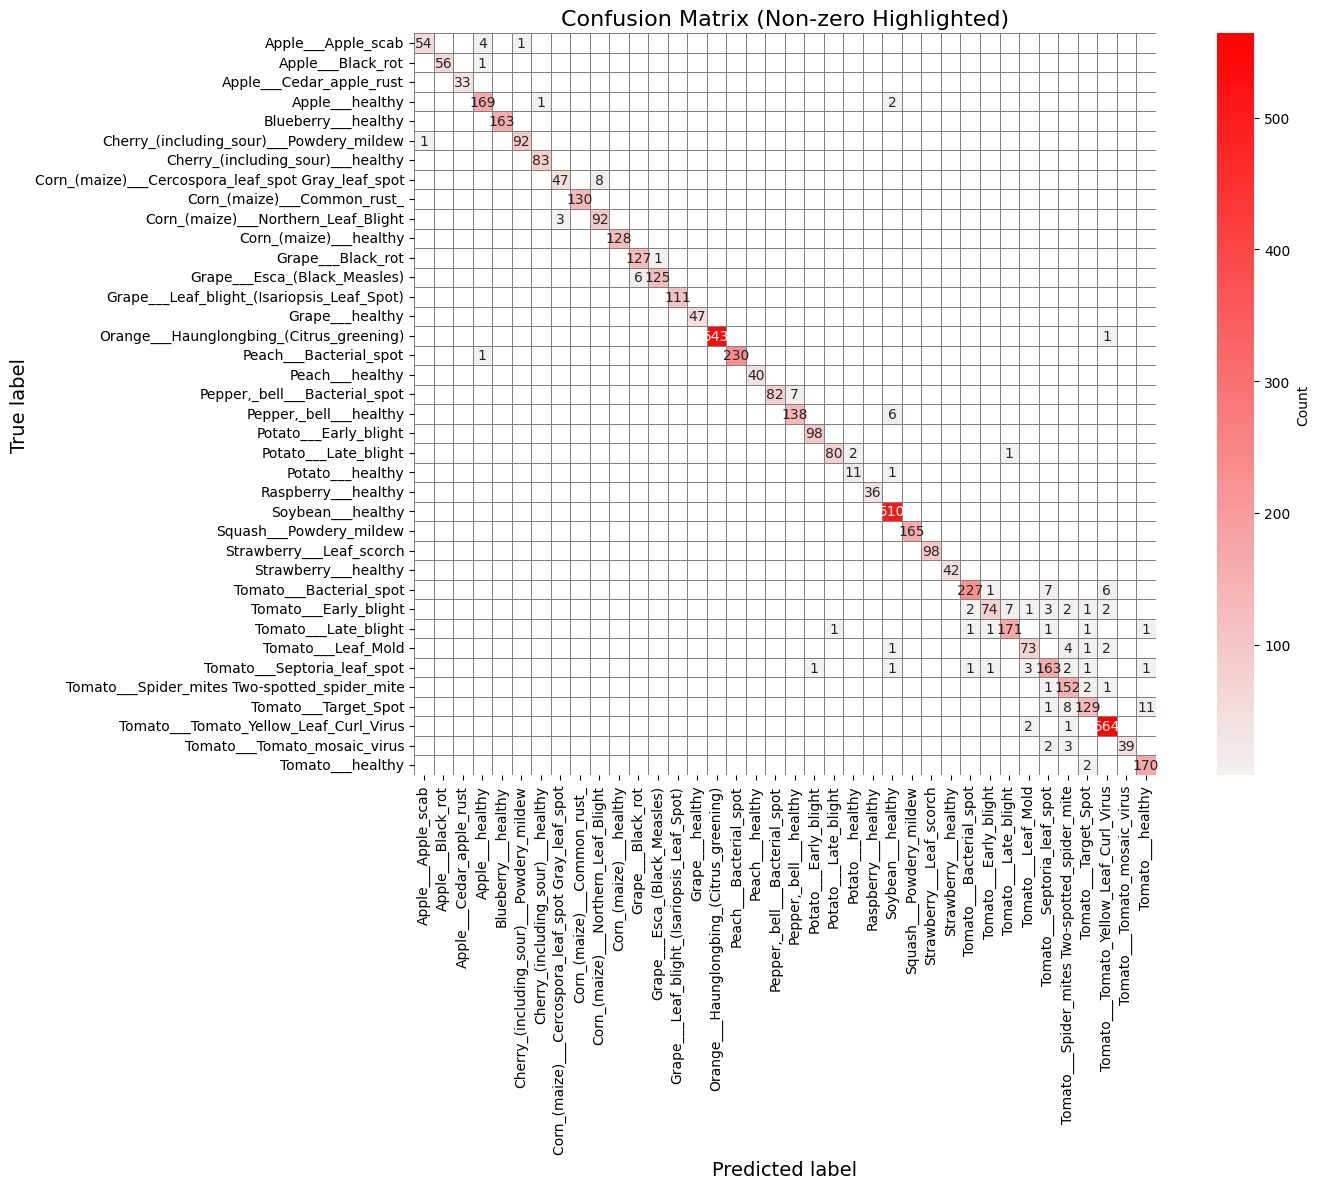

In [ ]:
# --- Enhanced Confusion Matrix Plot ---
plt.figure(figsize=(16, 12))
# Create a custom mask to highlight non-zero cells
mask = (cm == 0)
sns.heatmap(
    cm,
    mask=mask,  # hide zero cells
    annot=True,
    fmt="d",
    cmap=sns.light_palette("red", as_cmap=True),
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Count'}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Confusion Matrix (Non-zero Highlighted)", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.tight_layout()
plt.show()